In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GRU, Embedding, Input, concatenate, Conv1D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, roc_curve

## Preprocess

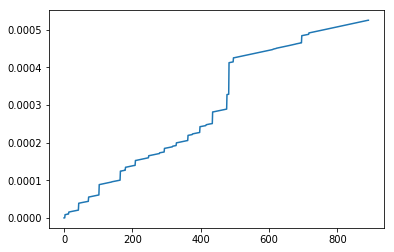

In [42]:
from data import preprocess
data = preprocess.preprocess('data/raw/CD_PD.mat')
label = data['diagnosis'].astype('int32')

def normalize_mean(data):
    for i in range(len(data)):
        data[i] = data[i] - np.mean(data[i])
    return data

# Normalize Mean
data_x = normalize_mean(data['x'])
data_y = normalize_mean(data['y'])
data_p = normalize_mean(data['p'])

plt.plot(data['t'][0])

[2.         2.24489796 2.48979592 2.73469388 2.97959184 3.2244898
 3.46938776 3.71428571 3.95918367 4.20408163 4.44897959 4.69387755
 4.93877551 5.18367347 5.42857143 5.67346939 5.91836735 6.04081633
 6.10204082 6.16326531 6.2244898  6.28571429 6.34693878 6.40816327
 6.46938776 6.53061224 6.59183673 6.65306122 6.71428571 6.7755102
 6.83673469 6.89795918 6.95918367 7.02040816 7.08163265 7.14285714
 7.20408163 7.26530612 7.32653061 7.3877551  7.44897959 7.51020408
 7.57142857 7.63265306 7.69387755 7.75510204 7.81632653 7.87755102
 7.93877551 8.        ]


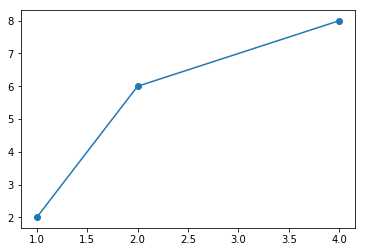

In [46]:
import numpy as np
import matplotlib.pyplot as plt

xp = [1, 2, 4]
yp = [2, 6, 8]
x = np.linspace(1, 4, 50)
y = np.interp(x, xp, yp)
print(y)

plt.scatter(xp, yp)
plt.plot(x, y)
plt.show()

## FFT

In [ ]:
WINDOW_SIZE = 30
WINDOW_PAD = 3

def signal_fft(signal):
    res = []
    sig_len = len(signal)
    # plt.figure(figsize=(15,5))
    for i in range(0, sig_len, WINDOW_PAD):
        if i + WINDOW_SIZE > sig_len:
            break
        sig_fft = np.absolute(np.fft.fft(signal[i: i + WINDOW_SIZE]))
        res.append(sig_fft)
        # plt.plot(sig_fft)
    # plt.show()
    return res

def signal_fft_component(signal, pt, plot=False, n_lines=10):
    res, temp = [], []
    c = 0
    if plot: 
        plt.figure(figsize=(13, 4))
        plt.xlim(0, 50)
        plt.ylim(-10, 10)
    for i in range(len(signal)):
        if pt[i] != 2:
            if len(temp) > WINDOW_SIZE:
                sig_fft = np.absolute(np.fft.fft(temp))
                res.append(sig_fft[:WINDOW_SIZE])
                if plot and c < n_lines: 
                    plt.plot(sig_fft)
                    c += 1
            temp = []
        else:
            temp.append(signal[i])
    if plot: plt.show()
    return res

# Non PD
# signal_fft_component(data['p'][0], data['pt'][0], True)
# signal_fft_component(data['p'][55], data['pt'][55], True)

# PD
# signal_fft_component(data['p'][191], data['pt'][191], True)
# signal_fft_component(data['p'][170], data['pt'][170], True)

In [ ]:
def signal_preprocess(data, label, pt_data=None):
    X_data, y_data = [], []
    for i in range(len(data)):
        # fft_com = signal_fft_component(data[i], pt_data[i])
        fft_com = signal_fft(data[i])
        X_data += fft_com
        y_data += [label[i]] * len(fft_com)      
    return np.array(X_data), np.array(y_data)

X_data, y_data = signal_preprocess(data['p'], label)

In [ ]:
print(X_data.shape, y_data.shape)

In [ ]:
def get_cnn_model(window_size):
    adam = Adam(lr=1e-4)
    model = Sequential()
    model.add(Conv1D(16, kernel_size=5, input_shape=(window_size, 1)))
    model.add(MaxPooling1D(pool_size=6, padding='same'))
    model.add(Conv1D(16, kernel_size=5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=adam)
    model.build()
    return model

model = get_cnn_model(WINDOW_SIZE)
model.summary()

In [39]:
# Split train test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)
print(X_train.shape, X_test.shape)
X_train = X_train.reshape(*X_train.shape, 1)
X_test = X_test.reshape(*X_test.shape, 1)
print(X_train.shape, X_test.shape)
model = get_cnn_model(WINDOW_SIZE)
model.fit(X_train, y_train, batch_size=32, 
    epochs=150, verbose=1, validation_data=(X_test, y_test))
model.evaluate(X_test, y_test)

(48344, 30) (12086, 30)
(48344, 30, 1) (12086, 30, 1)
Train on 48344 samples, validate on 12086 samples
Epoch 1/150
48344/48344 [==============================] - 10s 199us/step - loss: 0.6504 - val_loss: 0.6454
Epoch 2/150
48344/48344 [==============================] - 8s 158us/step - loss: 0.6428 - val_loss: 0.6412
Epoch 3/150
48344/48344 [==============================] - 8s 174us/step - loss: 0.6399 - val_loss: 0.6392
Epoch 4/150
48344/48344 [==============================] - 8s 160us/step - loss: 0.6372 - val_loss: 0.6363
Epoch 5/150
48344/48344 [==============================] - 8s 171us/step - loss: 0.6349 - val_loss: 0.6339
Epoch 6/150
48344/48344 [==============================] - 9s 180us/step - loss: 0.6326 - val_loss: 0.6330
Epoch 7/150
48344/48344 [==============================] - 8s 168us/step - loss: 0.6307 - val_loss: 0.6306
Epoch 8/150
48344/48344 [==============================] - 8s 174us/step - loss: 0.6295 - val_loss: 0.6291
Epoch 9/150
48344/48344 [==============

KeyboardInterrupt: 

In [ ]:
def eval_score(model, X_test, y_test, THRESHOLD = 0.5, report = False):
    y_pred = model.predict(X_test, batch_size=64, verbose=1).reshape(-1)
    y_pred_bool = np.where(y_pred < THRESHOLD, 0, 1)
    if report:
        print(classification_report(y_test, y_pred_bool, target_names=['No PD', 'PD']))
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.plot(fpr, tpr)
        
    acc = accuracy_score(y_test, y_pred_bool)
    return acc

eval_score(model, X_test, y_test, report=True)